_ Thay đổi Q(t-1), Sử dụng thêm num_head --> 8

In [1]:
!pip install dgl-cu113 dglgo -f https://data.dgl.ai/wheels/repo.html

Looking in links: https://data.dgl.ai/wheels/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.9/112.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 44.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7028 sha256=84766e5f9fdd7f8196264f0cebff91e4e100da836594f94686c39d919b234203
  Stored in directory

In [2]:
import dgl
import dgl.nn as dgl_nn
import dgl.function as dgl_func
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
#from GraphTransformer.layer import *
#from metra import *
#from utils import *
from tqdm.notebook import tqdm
from IPython.display import clear_output
import scipy.sparse as sp
import math
import zipfile

import os
import ssl
from six.moves import urllib
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(123)

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


## Dataset

In [3]:
def download_file(dataset):
    print("Start Downloading data: {}".format(dataset))
    url = "https://s3.us-west-2.amazonaws.com/dgl-data/dataset/{}".format(
        dataset)
    print("Start Downloading File....")
    context = ssl._create_unverified_context()
    data = urllib.request.urlopen(url, context=context)
    with open("./data/{}".format(dataset), "wb") as handle:
        handle.write(data.read())


class SnapShotDataset():
    def __init__(self, path, npz_file):
        if not os.path.exists(path+'/'+npz_file):
            if not os.path.exists(path):
                os.mkdir(path)
            download_file(npz_file)
        zipfile = np.load(path+'/'+npz_file)
        self.x = zipfile['x']
        self.y = zipfile['y']

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.x[idx, ...], self.y[idx, ...]


def METR_LAGraphDataset():
    if not os.path.exists('data/graph_la.bin'):
        if not os.path.exists('data'):
            os.mkdir('data')
        download_file('graph_la.bin')
    g, _ = dgl.load_graphs('data/graph_la.bin')
    return g[0]


class METR_LATrainDataset(SnapShotDataset):
    def __init__(self):
        super(METR_LATrainDataset, self).__init__('data', 'metr_la_train.npz')
        #self.mean = self.x[..., 0].mean()
        #self.std = self.x[..., 0].std()
        print(self.x.shape)
        self.mean = np.mean(self.x, axis = (0,1,2))
        self.std = np.std(self.x, axis = (0,1,2))


class METR_LATestDataset(SnapShotDataset):
    def __init__(self):
        super(METR_LATestDataset, self).__init__('data', 'metr_la_test.npz')


class METR_LAValidDataset(SnapShotDataset):
    def __init__(self):
        super(METR_LAValidDataset, self).__init__('data', 'metr_la_valid.npz')


def PEMS_BAYGraphDataset():
    if not os.path.exists('data/graph_bay.bin'):
        if not os.path.exists('data'):
            os.mkdir('data')
        download_file('graph_bay.bin')
    g, _ = dgl.load_graphs('data/graph_bay.bin')
    return g[0]


class PEMS_BAYTrainDataset(SnapShotDataset):
    def __init__(self):
        super(PEMS_BAYTrainDataset, self).__init__(
            'data', 'pems_bay_train.npz')
        self.mean = np.mean(self.x, axis = (0,1,2))

        self.std = np.std(self.x, axis = (0,1,2))


class PEMS_BAYTestDataset(SnapShotDataset):
    def __init__(self):
        super(PEMS_BAYTestDataset, self).__init__('data', 'pems_bay_test.npz')


class PEMS_BAYValidDataset(SnapShotDataset):
    def __init__(self):
        super(PEMS_BAYValidDataset, self).__init__(
            'data', 'pems_bay_valid.npz')

In [ ]:
for idx, (x, y) in enumerate(train_loader):
  data_node_0 = x[0,:,0,:] # data_x tại vị trí = 0, tất cả sequence, node = 0
  data_node_0_y = y[0,:,0,:] # data_y tại vị trí = 0, tất cả sequence, node = 0
  print(data_node_0)
  print('-------')
  print(data_node_0_y)
  break

tensor([[65.7500,  0.4931],
        [65.1111,  0.4965],
        [63.0000,  0.5000],
        [65.6667,  0.5035],
        [67.7500,  0.5069],
        [66.8750,  0.5104],
        [65.6250,  0.5139],
        [65.3333,  0.5174],
        [64.7500,  0.5208],
        [63.6250,  0.5243],
        [61.5556,  0.5278],
        [63.8750,  0.5312]], dtype=torch.float64)
-------
tensor([[63.4444,  0.5347],
        [64.8750,  0.5382],
        [64.0000,  0.5417],
        [62.3333,  0.5451],
        [63.3750,  0.5486],
        [61.5556,  0.5521],
        [61.1250,  0.5556],
        [59.4444,  0.5590],
        [61.6250,  0.5625],
        [63.5000,  0.5660],
        [64.8889,  0.5694],
        [61.3750,  0.5729]], dtype=torch.float64)


## Model

### Attention and Transformer Blocks

In [20]:
class MultiHeadAttention(nn.Module):
    def __init__(self, in_dim, dim, num_head, bias):
        super().__init__()
        assert dim % num_head == 0, "Unexpected embedding dimension"

        self.head_dim = dim // num_head
        self.num_head = num_head
        self.scale = 1./(dim ** (0.5))

        self.Wq_c = nn.Linear(in_dim, dim, bias=bias)
        self.Wq_p = nn.Linear(in_dim, dim, bias=bias)
        self.Wk = nn.Linear(in_dim, dim, bias=bias)
        self.Wv = nn.Linear(in_dim, dim, bias=bias)

    def _reshape_qkv(self, q_c, q_p, k, v):
        '''
            q, k, v: (N, D_h * N_h)
            return: (N, N_h, D_h)
        '''
        q_c = q_c.view(-1, self.num_head, self.head_dim)
        q_p = q_p.view(-1, self.num_head, self.head_dim)
        k = k.view(-1, self.num_head, self.head_dim)
        v = v.view(-1, self.num_head, self.head_dim)
        return q_c, q_p, k, v

    def query_by_current_state(self, edges):
        Q, K = edges.dst['Q_c'], edges.src['K']
        score = (Q * K).sum(-1, keepdim = True)
        score = score * self.scale
        score = torch.exp(score.clamp(-5,5))
        return {'score_c': score}

    def query_by_previous_state(self, edges):
        Q, K = edges.dst['Q_p'], edges.src['K']
        score = (Q * K).sum(-1, keepdim = True)
        score = score * self.scale
        score = torch.exp(score.clamp(-5,5))
        return {'score_p': score}

    def propagate_attention(self, g):
        g.apply_edges(self.query_by_current_state)
        g.apply_edges(self.query_by_previous_state)
        eids = g.edges()

        g.send_and_recv(eids, message_func = dgl_func.src_mul_edge('V', 'score_c', 'V'), reduce_func= dgl_func.sum('V', 'SV_c'))
        #g.send_and_recv(eids, message_func = dgl_fnc.copy_edge('score_c', 'score_c'), reduce_func = dgl_fnc.sum('score_c', 'z_c'))

        g.send_and_recv(eids, message_func = dgl_func.src_mul_edge('V', 'score_p', 'V'), reduce_func= dgl_func.sum('V', 'SV_p'))
        #g.send_and_recv(eids, message_func = dgl_fnc.copy_edge('score_p', 'score_p'), reduce_func = dgl_fnc.sum('score_p', 'z_p'))

    def forward(self, g, h_c, h_p,W_p_weight,W_p_bias):
        with g.local_scope():
            self.Wq_p.load_state_dict({'weight':W_p_weight,'bias':W_p_bias}) #load weight and bias from W_c at previous state
            Q_c, K, V, Q_p = self.Wq_c(h_c), self.Wk(h_c), self.Wv(h_c), self.Wq_p(h_p)
            Q_c, Q_p, K, V = self._reshape_qkv(Q_c, Q_p, K, V)
            g.ndata['Q_c'] = Q_c
            g.ndata['Q_p'] = Q_p
            g.ndata['K'] = K
            g.ndata['V'] = V
            self.propagate_attention(g)
            h_c = g.ndata['SV_c'] #/ (g.ndata['z_c'] + torch.full_like(g.ndata['z_c'], 1e-6))
            h_c = h_c.view(-1, self.head_dim * self.num_head)
            h_p = g.ndata['SV_p'] #/ (g.ndata['z_p'] + torch.full_like(g.ndata['z_p'], 1e-6))
            h_p = h_p.view(-1, self.head_dim * self.num_head)
            return h_c, h_p

class ST_Block(nn.Module):
    def __init__(self, in_dim, out_dim, num_head, bias = True, dropout = 0.25, norm = "LayerNorm"):
        super().__init__()
        self.dropout = dropout
        self.multihead_attention = MultiHeadAttention(in_dim, out_dim, num_head, bias)
        self.Wo_c = nn.Linear(out_dim, in_dim, bias = bias)
        self.Wo_p = nn.Linear(out_dim, in_dim, bias = bias)

        if norm == 'LayerNorm':
            self.norm_c = nn.LayerNorm(in_dim)
            self.norm_p = nn.LayerNorm(in_dim)
            self.norm_r = nn.LayerNorm(in_dim)
        else:
            self.norm_c = nn.BatchNorm1d(in_dim)
            self.norm_p = nn.BatchNorm1d(in_dim)
            self.norm_r = nn.BatchNorm1d(in_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_dim * 2, in_dim * 2),
            nn.ReLU(),
            nn.Linear(in_dim * 2, in_dim)
        )
        self.residual = nn.Linear(in_dim * 2, in_dim)

    def forward(self, g, h_c, h_p, W_p_weight, W_p_bias):
        h_r_c, h_r_p = h_c, h_p
        h_c, h_p = self.multihead_attention(g, h_c, h_p, W_p_weight, W_p_bias)
        W_p_weights = self.multihead_attention.Wq_c.state_dict()['weight']
        W_p_biases = self.multihead_attention.Wq_c.state_dict()['bias']
        h_c, h_p = self.Wo_c(h_c), self.Wo_p(h_p)

        h_c = self.norm_c(h_c + h_r_c)
        h_p = self.norm_p(h_p + h_r_p)

        h = torch.cat([h_c, h_p], dim = -1)
        h_r = self.residual(h)
        h = self.mlp(h)
        h = self.norm_r(h + h_r)
        return h,W_p_weights,W_p_biases

In [ ]:
multi_attend = MultiHeadAttention(12,48,4,True)
W_p_weight = multi_attend.Wq_p.state_dict()['weight']
W_p_bias = multi_attend.Wq_p.state_dict()['bias']

In [ ]:
W_p_weight.shape

torch.Size([48, 12])

In [ ]:
W_p_bias.shape

torch.Size([48])

### Encoder, Decoder, and Model

In [21]:
class Encoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, K, dim, num_head, bias = False, norm = "LayerNorm", num_steps = 5):
        super().__init__()
        self.num_steps = num_steps
        self.blocks = nn.ModuleList([
            ST_Block(hidden_dim, dim, num_head, bias = bias, norm = norm)
            for i in range(self.num_steps)
        ])
        self.node_embedding = nn.Linear(in_dim, hidden_dim)
        self.pos_embedding = nn.Linear(K, hidden_dim)
        self.hidden_dim = hidden_dim
        self.dim = dim

    def forward(self, g, H):
        # H (num_steps, num_nodes, num_features)
        lap_pos = g.ndata['lap_pos']
        lap_pos = self.pos_embedding(lap_pos)
        state = None
        for i in range(self.num_steps):
            h = H[i, :, :]
            h = self.node_embedding(h) + lap_pos
            if state is None:
                state = torch.zeros_like(h)
                W_p_weight = torch.zeros_like(torch.empty(self.dim,self.hidden_dim))
                W_p_bias = torch.zeros_like(torch.empty(self.dim))
            state,W_p_weight,W_p_bias = self.blocks[i](g, h, state, W_p_weight, W_p_bias)
        return state


class Decoder(nn.Module):
    def __init__(self, out_dim, hidden_dim, K,dim, num_head, bias = False, norm = "LayerNorm", num_steps = 5):
        super().__init__()
        self.num_steps = num_steps
        self.hidden_dim = hidden_dim
        self.dim = dim
        self.blocks = nn.ModuleList([
            ST_Block(hidden_dim, dim, num_head, bias = bias, norm = norm)
            for i in range(self.num_steps)
        ])
        self.node_embedding = nn.Linear(hidden_dim, hidden_dim) # load all 12 sequence = hidden_dim
        self.pos_embedding = nn.Linear(K, hidden_dim)
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def _train(self, g, encoder_output, target):
        num_node,_ = target.shape
        outputs = torch.zeros(self.num_steps, num_node,dtype = target.dtype, device = target.device)
        state = encoder_output
        h = target
        h = self.node_embedding(h) + self.lap_pos
        for i in range(self.num_steps):
            if i == 0:
              W_p_weight = torch.rand(self.dim,self.hidden_dim)
              W_p_bias = torch.rand(self.dim)
            state,W_p_weight,W_p_bias = self.blocks[i](g, h, state, W_p_weight, W_p_bias)
            out = self.output_layer(state)
            outputs[i] = out.squeeze()
        return outputs

    '''def _infer(self, g, encoder_output, last):
        num_node, _ = last.shape
        outputs = torch.zeros(self.num_steps, num_node, dtype = last.dtype, device = last.device)
        state = encoder_output
        out = None
        for i in range(self.num_steps):
            h = self.node_embedding(last) + self.lap_pos
            state = self.blocks[i](g, h, state)
            out = self.output_layer(state)
            last = out
            outputs[i] = out.squeeze()
        return outputs'''

    def forward(self, g, encoder_output, target):
        lap_pos = g.ndata['lap_pos']
        self.lap_pos = self.pos_embedding(lap_pos)
        #target = target.unsqueeze(-1)
        return self._train(g, encoder_output, target)

class STGraphTransformers(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, K, dim, num_head, bias = False, norm = "LayerNorm", num_encode_steps = 5, num_decode_steps = 5):
        super().__init__()
        self.encoder = Encoder(in_dim, hidden_dim, K,dim, num_head, bias, norm, num_encode_steps)
        self.decoder = Decoder(out_dim ,hidden_dim, K,dim, num_head, bias, norm, num_decode_steps)

        self.readout = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim)
        )
    def forward(self, g, x, target):
        state = self.encoder(g, x)
        #last = x[-1, :, 0].unsqueeze(-1) # chỉ lấy data_x[0] vì đầu vào target có dim = 1
        state = self.readout(state)
        return self.decoder(g, state, target) # last is the last x in sequence -- target is y at current

## Load Data

In [ ]:
'''def calculate_lap_pos(g, k):
    A = sparse.coo_matrix.todense(g.adj(scipy_fmt = 'coo'))
    A = np.array(A)
    L = calculate_normalized_laplacian(A)
    lap_pos = laplacian_positional_encoding(L, k)
    lap_pos = np.real(lap_pos)
    return lap_pos
# Chưa có hàm calculate_normalized_laplacian --> tự viết lại'''

In [6]:
def positional_encoding(g, pos_enc_dim):
    """
        Graph positional encoding v/ Laplacian eigenvectors
    """

    # Laplacian
    A = g.adjacency_matrix_scipy(return_edge_ids=False).astype(float)
    N = sp.diags(dgl.backend.asnumpy(g.in_degrees()).clip(1) ** -0.5, dtype=float)
    L = sp.eye(g.number_of_nodes()) - N * A * N

    # Eigenvectors with numpy
    EigVal, EigVec = np.linalg.eig(L.toarray())
    idx = EigVal.argsort() # increasing order
    EigVal, EigVec = EigVal[idx], np.real(EigVec[:,idx])
    lap_pos = torch.from_numpy(EigVec[:,1:pos_enc_dim+1]).float()

    # # Eigenvectors with scipy
    # EigVal, EigVec = sp.linalg.eigs(L, k=pos_enc_dim+1, which='SR')
    # EigVec = EigVec[:, EigVal.argsort()] # increasing order
    # g.ndata['pos_enc'] = torch.from_numpy(np.abs(EigVec[:,1:pos_enc_dim+1])).float()

    return lap_pos

In [7]:
g = METR_LAGraphDataset()
train_data = METR_LATrainDataset()
test_data = METR_LATestDataset()
valid_data = METR_LAValidDataset()

#g = PEMS_BAYGraphDataset()
#train_data = PEMS_BAYTrainDataset()
#test_data = PEMS_BAYTestDataset()
#valid_data = PEMS_BAYValidDataset()

#tạo khuyên làm gì?
#g = dgl.add_self_loop(g)

#num_node = g.num_nodes()
#num_edges = g.num_edges()


#print("Mean: ", mean)
#print("Std: ", std)
#print("Num node", num_node)
#print("Num edge: ", num_edges)

Start Downloading data: graph_la.bin
Start Downloading File....
Start Downloading data: metr_la_train.npz
Start Downloading File....
(23974, 12, 207, 2)
Start Downloading data: metr_la_test.npz
Start Downloading File....
Start Downloading data: metr_la_valid.npz
Start Downloading File....


In [ ]:
print("Train size: ", len(train_data))
print("Valid size: ", len(valid_data))
print("Test size: ", len(test_data))

Train size:  23974
Valid size:  3425
Test size:  6850


In [8]:
lap_pos = positional_encoding(g, 100)
#lap_pos = torch.tensor(lap_pos).float()
g.ndata['lap_pos'] = lap_pos

/usr/local/lib/python3.10/dist-packages/dgl/heterograph.py:3719: DGLWarning: DGLGraph.adjacency_matrix_scipy is deprecated. Please replace it with:

	DGLGraph.adjacency_matrix(transpose, scipy_fmt="csr").

  dgl_warning('DGLGraph.adjacency_matrix_scipy is deprecated. '


In [9]:
# Transform data - Add thêm 1 chiều thời gian vào data
# Make sample Time
sample = np.array([i for i in range(1,2017)]) #5 phút 1 lần -> 7 ngày sẽ có 12*24*7 = 2016

# Transform
x_train = train_data.x
x_valid = valid_data.x
x_test = test_data.x
x = np.concatenate((x_train,x_valid,x_test),axis = 0)
num_record,seq,num_node,dim = x.shape
x = x.reshape(num_record,seq*num_node,dim)

pos = 0
x_final = []
for i in range(len(x)):
  if pos == 2016:
    pos = 0
  k = np.c_[x[i],np.array([sample[pos]]*2484)]
  x_final.append(k)
  pos += 1
x_final = np.array(x_final)

x_train = x_final[0:23974,:,:]
x_valid = x_final[23974:23974+3425,:,:]
x_test = x_final[23974+3425:,:,:]
x_train = x_train.reshape(23974,12,207,3)
x_valid = x_valid.reshape(3425,12,207,3)
x_test = x_test.reshape(6850,12,207,3)

mean = np.mean(x_train,axis = (0,1,2))
std = np.std(x_train,axis = (0,1,2))
mean = mean.reshape(1,1,-1)
std = std.reshape(1,1,-1)
print('mean:',mean)
print('std:',std)

y_train = train_data.y
y_valid = valid_data.y
y_test = test_data.y

train_data_last = list(zip(x_train,y_train))
valid_data_last = list(zip(x_valid,y_valid))
test_data_last = list(zip(x_test,y_test))

mean: [[[5.44059283e+01 4.97214575e-01 1.00032523e+03]]]
std: [[[1.94937393e+01 2.88928710e-01 5.78200406e+02]]]


In [10]:
#collate_fn
def collate_fn(batch):
  x_list,y_list = [],[]
  for (x,y) in batch:
    x_list.append(x)
    y_list.append(y)
  x_list = np.array(x_list)
  y_list = np.array(y_list)
  return torch.tensor(x_list),torch.tensor(y_list)

batch_size = 256

In [11]:
train_loader = DataLoader(train_data_last, batch_size= batch_size, num_workers= 2, shuffle=True, collate_fn = collate_fn)
valid_loader = DataLoader(valid_data_last, batch_size= batch_size, num_workers= 2, shuffle=False, collate_fn = collate_fn)
test_loader  = DataLoader(test_data_last,  batch_size= batch_size, num_workers= 2, shuffle=False, collate_fn = collate_fn)

In [ ]:
for idx,(x,y) in enumerate(train_loader):
  if idx == last_train:
    print('train_loader')
    print(x[-1,:,-1,0],y[-1,:,-1,0])
for idx,(x,y) in enumerate(valid_loader):
  if idx == 0:
    print('begin_valid')
    print(x[0,:,-1,0],y[0,:,-1,0])
    print()
  elif idx == last_valid:
    print('last_valid')
    print(x[-1,:,-1,0],y[-1,:,-1,0])
for idx,(x,y) in enumerate(test_loader):
  print('begin_test')
  print(x[0,:,-1,0],y[0,:,-1,0])
  break

# kết quả cho thấy dữ liệu là liên tục giữa 3 tập

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [12]:
def masked_mae_loss(y_pred, y_true,test=True):
    mask = (y_true != 0).float()
    mask /= mask.mean()
    loss = torch.abs(y_pred - y_true)
    loss = loss * mask
    # trick for nans: https://discuss.pytorch.org/t/how-to-set-nan-in-tensor-to-0/3918/3
    loss[loss != loss] = 0
    loss_12 =  loss.mean()

    mask_6 = (y_true[:6] != 0).float()
    mask_6 /= mask_6.mean()
    loss_6 = torch.abs(y_pred[:6] - y_true[:6])
    loss_6 = loss_6 * mask_6
    loss_6[loss_6 != loss_6] = 0
    loss_6_ = loss_6.mean()

    mask_3 = (y_true[:3] != 0).float()
    mask_3 /= mask_3.mean()
    loss_3 = torch.abs(y_pred[:3] - y_true[:3])
    loss_3 = loss_3 * mask_3
    loss_3[loss_3 != loss_3] = 0
    loss_3_ = loss_3.mean()
    if test == True:
      return torch.tensor([loss_12,loss_6_,loss_3_])
    else:
      return loss_12

def masked_mse_loss(y_pred, y_true):
    mask = (y_true != 0).float()
    mask /= mask.mean()
    loss = (y_pred - y_true)**2
    loss = loss * mask
    # trick for nans: https://discuss.pytorch.org/t/how-to-set-nan-in-tensor-to-0/3918/3
    loss[loss != loss] = 0
    loss_12 = loss.mean()

    mask_6 = (y_true[:6] != 0).float()
    mask_6 /= mask_6.mean()
    loss_6 = (y_pred[:6] - y_true[:6])**2
    loss_6 = loss_6 * mask_6
    loss_6[loss_6 != loss_6] = 0
    loss_6_ = loss_6.mean()

    mask_3 = (y_true[:3] != 0).float()
    mask_3 /= mask_3.mean()
    loss_3 = (y_pred[:3] - y_true[:3])**2
    loss_3 = loss_3 * mask_3
    loss_3[loss_3 != loss_3] = 0
    loss_3_ = loss_3.mean()

    return torch.tensor([loss_12,loss_6_,loss_3_])

def masked_mape_loss(y_pred, y_true):
    mask = (y_true != 0).float()
    mask /= mask.mean()
    loss = (y_true - y_pred).abs() / y_true.abs()
    loss = loss * mask
    # trick for nans: https://discuss.pytorch.org/t/how-to-set-nan-in-tensor-to-0/3918/3
    loss[loss != loss] = 0
    loss_12 = loss.mean()

    mask_6 = (y_true[:6] != 0).float()
    mask_6 /= mask_6.mean()
    loss_6 = (y_pred[:6] - y_true[:6]).abs()/y_true[:6].abs()
    loss_6 = loss_6 * mask_6
    loss_6[loss_6 != loss_6] = 0
    loss_6_ = loss_6.mean()

    mask_3 = (y_true[:3] != 0).float()
    mask_3 /= mask_3.mean()
    loss_3 = (y_pred[:3] - y_true[:3]).abs()/y_true[:3].abs()
    loss_3 = loss_3 * mask_3
    loss_3[loss_3 != loss_3] = 0
    loss_3_ = loss_3.mean()

    return torch.tensor([loss_12,loss_6_,loss_3_])

## Load Model

In [22]:
model = STGraphTransformers(3, 12, 1, 100,12, 1, bias = True, norm = "LayerNorm", num_encode_steps = 12, num_decode_steps = 12).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0001, weight_decay = 0.001, momentum = 0.009)
#optimizer = torch.optim.Adagrad(model.parameters())
#optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.9)
loss_fn = masked_mae_loss

In [ ]:
# Run this cell when you already have a checkpoint
#checkpoint = torch.load('model_stt_week_day_sample.pt')
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
del model
torch.cuda.empty_cache()

## Train Function

In [16]:

best_loss = [100]
'''try:
    best_loss[0] = checkpoint['loss']
    epoch = checkpoint['epoch']
except:
    best_loss[0] = 100
    epoch = 0'''

"try:\n    best_loss[0] = checkpoint['loss']\n    epoch = checkpoint['epoch']\nexcept:\n    best_loss[0] = 100\n    epoch = 0"

In [ ]:
print("Best Loss: ", best_loss[0])
print("Epoch: ", epoch)

Best Loss:  3.422331447954531
Epoch:  86


In [17]:
import numpy as np
def train_1(model, g, train_loader, lap_pos, loss_fn, optimizer, batch_size, num_samples):
    total_loss = []
    model.train()
    for idx, (x, y) in tqdm(enumerate(train_loader), total = num_samples // batch_size):

        lap_pos = g.ndata['lap_pos']
        sign_flip = torch.rand(lap_pos.size(1))
        sign_flip[sign_flip>=0.5] = 1.0; sign_flip[sign_flip<0.5] = -1.0
        lap_pos = lap_pos * sign_flip.unsqueeze(0)
        g.ndata['lap_pos'] = lap_pos

        bs,seq_len, num_node, dim = x.shape

        batch_g = dgl.batch([g] * bs).to(device)
        # Chỉ lấy feature 0 của y để predict
        y = y[..., 0]
        x = x.permute(1, 0, 2, 3) # sequence, bs, num_node, dim = 3
        y = y.permute(1, 0, 2) # vì chỉ lấy dim[0] nên chiều dim biến mất

        x = x.reshape(seq_len, bs * num_node, dim).cpu().numpy()
        y = y.reshape(seq_len, bs * num_node).cpu().numpy()

        x = (x - mean) / std
        x = torch.tensor(x).float().clone().to(device)
        #y = torch.tensor(y).float().clone().to(device)
        targets = x.permute(1,0,2) #num_node,seq_len,dim
        targets = targets[...,0]

        targets = torch.tensor(targets).float().clone().to(device)
        # chiều dài targets và y là 11. với mỗi target sẽ predict y tại vị trí tương ứng
        y = torch.tensor(y).float().clone().to(device)

        optimizer.zero_grad()
        out = model(batch_g, x, targets) # out trả về chỉ có 11 điểm (11 num_steps)
        #out = scaler.inverse_scale(out, mean[0], std[0])
        out = out * std[0,0,0] + mean[0,0,0]

        loss = loss_fn(out, y,test = False)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()


        total_loss.append(loss.detach().item())
    return np.mean(total_loss)


def eval_1(model, g, val_loader, lap_pos, loss_fn, batch_size, num_samples):
    model.eval()
    total_loss = []
    for idx, (x, y) in tqdm(enumerate(val_loader), total = num_samples // batch_size):
        '''
        lap_pos = g.ndata['lap_pos']
        sign_flip = torch.rand(lap_pos.size(1))
        sign_flip[sign_flip>=0.5] = 1.0; sign_flip[sign_flip<0.5] = -1.0
        lap_pos = lap_pos * sign_flip.unsqueeze(0)
        '''
        g.ndata['lap_pos'] = lap_pos

        bs, seq_len, num_node, dim = x.shape

        batch_g = dgl.batch([g] * bs).to(device)

        y = y[..., 0]
        x = x.permute(1, 0, 2, 3)
        y = y.permute(1, 0, 2)

        x = x.reshape(seq_len, bs * num_node, dim).numpy()
        y = y.reshape(seq_len, bs * num_node).numpy()

        x = (x - mean) / std
        x = torch.tensor(x).float().clone().to(device)
        targets = x.permute(1,0,2)
        targets = targets[...,0]
        #targets = y[:-1]
        #targets = scaler.scale(targets, mean[0],std[0])
        #targets = (targets - mean[0,0,0])/std[0,0,0]
        #targets = torch.tensor(targets).float().clone().to(device)
        y = torch.tensor(y).float().clone().to(device)

        with torch.no_grad():
            out = model(batch_g, x, targets).squeeze()
        #out = scaler.inverse_scale(out, mean[0], std[0])
        out = out * std[0,0,0] + mean[0,0,0]

        loss = loss_fn(out, y,test = False)
        #loss = torch.sqrt(loss_fn(out, y))
        total_loss.append(loss.detach().item())
        del loss

    return np.mean(total_loss)

def test_1(model, g, val_loader, lap_pos, metrics, batch_size, num_samples, num_steps):
    model.eval()
    total_rmse = []
    total_rmse_6 = []
    total_rmse_3 = []
    total_mae = []
    total_mae_6 = []
    total_mae_3 = []
    total_mape = []
    total_mape_6 = []
    total_mape_3 = []
    predictions = []
    actuals = []
    for idx, (x, y) in tqdm(enumerate(val_loader), total = num_samples // batch_size):

        g.ndata['lap_pos'] = lap_pos

        bs, seq_len , num_node, dim = x.shape

        batch_g = dgl.batch([g] * bs).to(device)

        y = y[..., 0]
        x = x.permute(1, 0, 2, 3)
        y = y.permute(1, 0, 2)

        x = x.reshape(seq_len, bs * num_node, dim).cpu().numpy()
        y = y.reshape(seq_len, bs * num_node).cpu().numpy()

        x = (x - mean) / std

        x = torch.tensor(x).float().clone().to(device)
        targets = x.permute(1,0,2)
        targets = targets[...,0]
        y = torch.tensor(y).float().clone().to(device)

        with torch.no_grad():
            out = model(batch_g, x, targets).squeeze()
        out = out * std[0,0,0] + mean[0,0,0]
        # num_steps_out = 11 vì lấy block trước predict block sau

        #mae = metrics['mae'](out, y).detach().item()
        mae = metrics['mae'](out, y)[0].detach()
        mae_6 = metrics['mae'](out, y)[1].detach()
        mae_3 = metrics['mae'](out, y)[2].detach()
        rmse = torch.sqrt(metrics['mse'](out, y)[0]).detach()
        rmse_6 = torch.sqrt(metrics['mse'](out, y)[1]).detach()
        rmse_3 = torch.sqrt(metrics['mse'](out, y)[2]).detach()
        mape = metrics['mape'](out, y)[0].detach()
        mape_6 = metrics['mape'](out, y)[1].detach()
        mape_3 = metrics['mape'](out, y)[2].detach()

        total_mae.append(mae)
        total_mae_6.append(mae_6)
        total_mae_3.append(mae_3)
        total_rmse.append(rmse)
        total_rmse_6.append(rmse_6)
        total_rmse_3.append(rmse_3)
        total_mape.append(mape)
        total_mape_6.append(mape_6)
        total_mape_3.append(mape_3)

        out = out.detach().cpu().numpy().reshape(num_steps, bs, num_node)
        y = y.detach().cpu().numpy().reshape(num_steps, bs, num_node)

        out = np.transpose(out, axes = (1, 2, 0))
        y = np.transpose(y, axes = (1, 2, 0))

        predictions += out[:, -1, :].tolist()
        actuals += y[:, -1, :].tolist()

    return np.mean(total_mae), np.mean(total_mae_6), np.mean(total_mae_3), np.mean(total_rmse), np.mean(total_rmse_6), np.mean(total_rmse_3), np.mean(total_mape), np.mean(total_mape_6), np.mean(total_mape_3), predictions, actuals


## Train

In [23]:
epoch = 1
print("Best Loss", best_loss[0])
for e in range(1):
    print("Epoch: ", epoch + e)
    print("Best Validation Loss", best_loss[0])
    tmp_loss = best_loss[0]
    train_loss = train_1(model, g, train_loader, lap_pos, loss_fn, optimizer, batch_size, len(train_data))
    val_loss = eval_1(model, g, valid_loader, lap_pos, loss_fn, batch_size, len(valid_data))
    #print("Train Loss: {}".format(train_loss))
    print("Train Loss: {}, Val Loss: {}".format(train_loss, val_loss))

    if best_loss[0] > val_loss:
        best_loss[0] = val_loss
        torch.save({
                'epoch' : epoch + e,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss' : val_loss,
                }, '/content/drive/MyDrive/AISIA/TrafficNet/Development/Best/model_Transform_data_3d_gt.pt')
        print("------------- Saved model ------------")
    print()


Best Loss 100
Epoch:  1
Best Validation Loss 100


  0%|          | 0/93 [00:00<?, ?it/s]

<ipython-input-17-d4a3a532da84>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets).float().clone().to(device)
/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:352: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), "Cannot convert view " \


KeyboardInterrupt: ignored

## Test

In [ ]:
# Run this cell to load the model that is saved during training
checkpoint = torch.load('/content/drive/MyDrive/AISIA/TrafficNet/Development/Best/model_Transform_data_3d_gt.pt',map_location=device) #mo hinh gan seq-12 x h
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
model.eval()
'''try:
    best_loss[0] = checkpoint['loss']
    epoch = checkpoint['epoch']
except:
    best_loss[0] = 100
    epoch = 100'''

"try:\n    best_loss[0] = checkpoint['loss']\n    epoch = checkpoint['epoch']\nexcept:\n    best_loss[0] = 100\n    epoch = 100"

In [ ]:
best_loss = [loss]

In [ ]:
metrics = {
    'mae' : masked_mae_loss,
    'mse' : masked_mse_loss,
    'mape': masked_mape_loss
}
mae_loss_12, mae_loss_6, mae_loss_3, rmse_loss_12, rmse_loss_6, rmse_loss_3, mape_loss_12, mape_loss_6, mape_loss_3, predictions, gts = test_1(model, g, test_loader, lap_pos, metrics, batch_size, len(test_data), 12)
print("MAE_12: {}".format(mae_loss_12))
print("MAE_6: {}".format(mae_loss_6))
print("MAE_3: {}".format(mae_loss_3))

print("RMSE_12: {}".format(rmse_loss_12))
print("RMSE_6: {}".format(rmse_loss_6))
print("RMSE_3: {}".format(rmse_loss_3))

print("MAPE_12: {}".format(mape_loss_12))
print("MAPE_6: {}".format(mape_loss_6))
print("MAPE_3: {}".format(mape_loss_3))

  0%|          | 0/53 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/dgl/backend/pytorch/tensor.py:352: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), "Cannot convert view " \


MAE_12: 3.506930112838745
MAE_6: 3.025050640106201
MAE_3: 2.7054319381713867
RMSE_12: 6.887699604034424
RMSE_6: 5.807791709899902
RMSE_3: 5.01042366027832
MAPE_12: 0.10185939073562622
MAPE_6: 0.08240866661071777
MAPE_3: 0.07009310275316238


## Visualize

In [ ]:
len(gts)

6850

In [ ]:
print(predictions[210])
print(gts[210])

62.74760818481445
62.5


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def visualize(preds, gts, start, end, data):
    fig = plt.figure(figsize = (15,8))
    horizon = end - start
    x = np.arange(horizon)
    plt.plot(x, preds[start : end], label = 'Prediction')
    plt.plot(x, gts[start : end], label = 'Ground Truth')
    plt.legend(loc = "lower center")
    plt.show()

In [ ]:
predictions = np.array(predictions)
gts = np.array(gts)

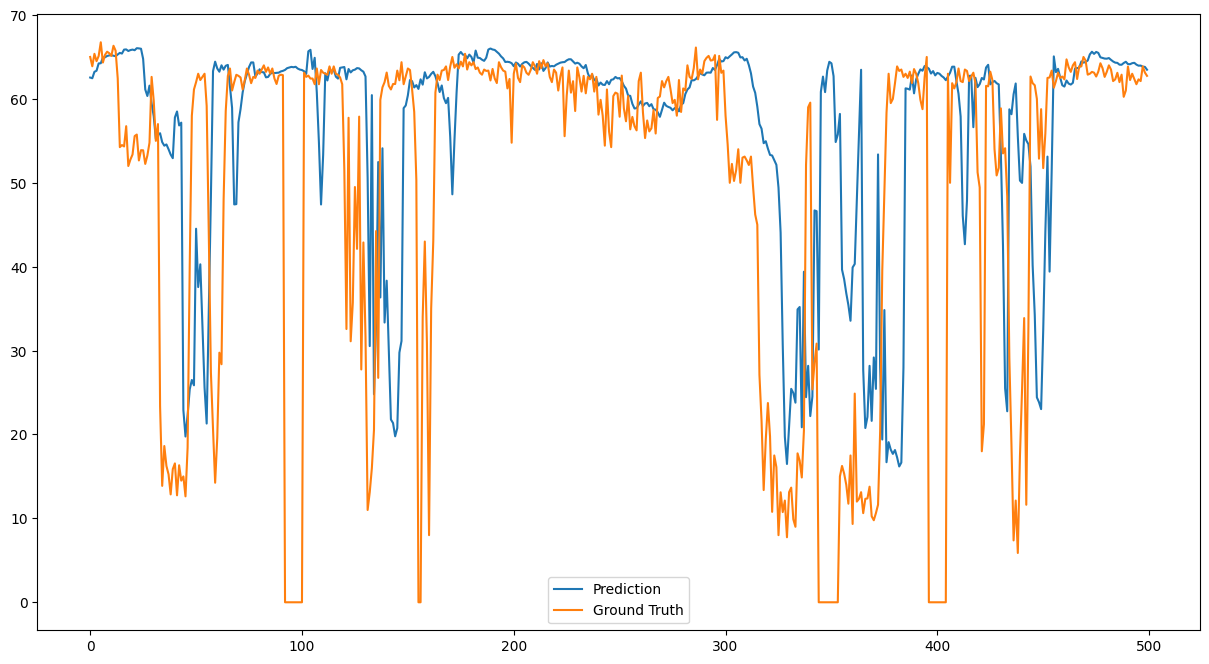

In [ ]:
visualize(predictions, gts, 0, 500, 'metrl')

In [ ]:
for id,(x,y) in enumerate(test_loader):
  test = [x[:,:,-1,0],y[:,:,-1,0]]
  break
print(test[0][55,:])
print(test[0][57,:])

tensor([23.3750, 13.8750, 18.6250, 16.2500, 15.2500, 12.8571, 15.8750, 16.5556,
        12.7500, 16.3333, 14.5000, 15.0000], dtype=torch.float64)
tensor([18.6250, 16.2500, 15.2500, 12.8571, 15.8750, 16.5556, 12.7500, 16.3333,
        14.5000, 15.0000, 12.6250, 18.4444], dtype=torch.float64)


In [ ]:

print(predictions[57])
print(predictions[56])
print(predictions[55])
print()
print(gts[57])
print(gts[56])

[19.60143280029297, 19.326541900634766, 19.320053100585938, 18.983882904052734, 20.152198791503906, 21.25057601928711, 22.86070442199707, 24.73822784423828, 27.115177154541016, 29.76022720336914, 32.032249450683594, 33.18064498901367]
[16.123096466064453, 14.910778045654297, 16.321197509765625, 16.15489959716797, 16.55789566040039, 18.168209075927734, 18.47946548461914, 19.450408935546875, 21.10382843017578, 21.876399993896484, 23.014394760131836, 22.478967666625977]
[17.23541259765625, 15.866058349609375, 17.12346649169922, 17.276477813720703, 17.23725128173828, 18.217205047607422, 17.567813873291016, 18.011470794677734, 19.05284881591797, 19.7322998046875, 20.701148986816406, 20.420154571533203]

[40.125, 58.0, 61.125, 62.0, 63.0, 62.25, 62.625, 63.0, 59.16666793823242, 43.88888931274414, 27.375, 20.625]
[18.44444465637207, 40.125, 58.0, 61.125, 62.0, 63.0, 62.25, 62.625, 63.0, 59.16666793823242, 43.88888931274414, 27.375]


In [ ]:
for id,(x,y) in enumerate(test_loader):
  for k in range(128):
    print(x[k,:,-1,0],y[k,:,-1,0])
  break
#mô tả data:
#gồm x và y tại 1 điểm node. Xuất hiện theo seq = 12 --> x là vân tốc hiện tại và y là vận tốc sau đó 1h.
#mỗi lần cập nhật lại sau 5p --> x xóa step 0 và thêm vào step 0 của y ở cuối seq

tensor([61.8889, 63.7500, 59.7778, 61.0000, 60.3750, 61.7500, 59.3750, 56.0000,
        62.8750, 60.5000, 63.1250, 62.2500], dtype=torch.float64) tensor([61.8750, 64.3750, 64.1111, 64.2500, 62.8750, 65.3333, 63.5000, 63.5000,
        63.8889, 63.8750, 65.0000, 63.8889], dtype=torch.float64)
tensor([63.7500, 59.7778, 61.0000, 60.3750, 61.7500, 59.3750, 56.0000, 62.8750,
        60.5000, 63.1250, 62.2500, 61.8750], dtype=torch.float64) tensor([64.3750, 64.1111, 64.2500, 62.8750, 65.3333, 63.5000, 63.5000, 63.8889,
        63.8750, 65.0000, 63.8889, 65.3750], dtype=torch.float64)
tensor([59.7778, 61.0000, 60.3750, 61.7500, 59.3750, 56.0000, 62.8750, 60.5000,
        63.1250, 62.2500, 61.8750, 64.3750], dtype=torch.float64) tensor([64.1111, 64.2500, 62.8750, 65.3333, 63.5000, 63.5000, 63.8889, 63.8750,
        65.0000, 63.8889, 65.3750, 64.5000], dtype=torch.float64)
tensor([61.0000, 60.3750, 61.7500, 59.3750, 56.0000, 62.8750, 60.5000, 63.1250,
        62.2500, 61.8750, 64.3750, 64.1111],

In [ ]:
import torch
a = torch.tensor([1,2,3])
a[1]

tensor(2)